# Training of the _Muon_ model 

In this notebook we setup the training for the GlobalPID model for particles that pass the isMuon criterion, based on Generative Adversarial Networks (GAN).

This notebook is part of a pipeline and requires the data preprocessed with the notebook [Muon-preprocessing.ipynb](./Muon-preprocessing.ipynb).

In [1]:
import os
from IPython.display import Markdown
from gpu_picker import request_gpu

LOCAL = os.environ.get("LOCAL", "yes").lower() in ['y', 'yes', 'true', '1']
TEST = os.environ.get("TEST", "yes").lower() in ['y', 'yes', 'true', '1']
SAMPLE = os.environ.get("SAMPLE", "2016MU")
PARTICLE = os.environ.get("PARTICLE", "pion").lower()

Markdown(f"""
 * LOCAL: `{LOCAL}`
 * SAMPLE: `{SAMPLE}`
 * TEST: `{TEST}`
 * PARTICLE: `{PARTICLE}`
 * REQUESTED GPU: `{request_gpu(True)}`

""")


 * LOCAL: `True`
 * SAMPLE: `2016MU`
 * TEST: `True`
 * PARTICLE: `pion`


## Enviornment setup and libraries

In this notebooks we will use the standard software stack for TensorFlow machine learning applications.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

To ensure a GPU is found and properly loaded in the notebook kernel to the benefit of TensorFlow, the output of the following block should be similar to `'/device:GPU:0'`.
If a GPU is not found, the string will be empty.

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Load datasets

Preprocessed datasets were stored in *Apache feather* format and can be reloaded with our custom `FeatherReader` designed to stream the datasets into TensorFlow or Dask format.

We are loading in particular:
 * the **training** dataset to train the network
 * the **validation** dataset to evaluate the network performance at each epoch and identify overtraining effects

In [4]:
DATA_PATH = os.environ.get("DATA_PATH", "/tmp")

In [5]:
from feather_io import FeatherReader    

MAX_FILES = int(os.environ.get("MAX_FILES", "1000"))

reader_train = FeatherReader(environ.get("MUON_TRAIN_DATA", f"{DATA_PATH}/Muon-{PARTICLE}-train"), max_files=MAX_FILES)
ds_train = reader_train.as_tf_dataset()

reader_val = FeatherReader(environ.get("MUON_VAL_DATA", f"{DATA_PATH}/Muon-{PARTICLE}-validation"), max_files=MAX_FILES)
ds_val = reader_val.as_tf_dataset()

We load a small batch of data to identify the shape of features and labels, and automate the definition of the neural network architecture.

In [6]:
x_vars = reader_train.features
y_vars = reader_train.labels

x_vars, y_vars

(['p_GeV', 'eta', 'nTracks_f', 'charge'], ['MuonMuLL', 'MuonBgLL'])

In [7]:
X, y = next(iter(ds_train.batch(500_000)))
X.shape, y.shape

(TensorShape([500000, 4]), TensorShape([500000, 2]))

In [8]:
y.numpy()

array([[ 0.63186944,  1.1461216 ],
       [ 0.5298768 ,  0.11242494],
       [ 0.60799885,  1.0990107 ],
       ...,
       [ 0.6545912 ,  1.1538988 ],
       [-4.117617  , -1.8153143 ],
       [-3.1081583 , -2.4936657 ]], dtype=float32)

## Model definition

TBA

In [9]:
from training_utils import create_models

generator, discriminator, referee = create_models(
    'Muon', 
    PARTICLE, 
    output_dim=y.shape[1], 
    model_filename=os.environ.get("MODEL_YAML_FILE")
)

### Generator architecture

TBA

In [10]:
generator._hidden_activation_func = "relu"

generator(X[:256])
generator.summary()

Model: "generator_func"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 68)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_0 (Dense)     │ (None, 128)       │      8,832 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_0        │ (None, 128)       │          0 │ dense_0[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_0 (Dropout) │ (None, 128)       │          0 │ leaky_relu_0[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dropout_0[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_1        │ (None, 128)       │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ leaky_relu_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_0-1 (Add)       │ (None, 128)       │          0 │ dropout_0[0][0],  │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ add_0-1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_2        │ (None, 128)       │          0 │ dense_2[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ leaky_relu_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1-2 (Add)       │ (None, 128)       │          0 │ add_0-1[0][0],    │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ add_1-2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_3        │ (None, 128)       │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ leaky_relu_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2-3 (Add)       │ (None, 128)       │          0 │ add_1-2[0][0],    │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ add_2-3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_4        │ (None, 128)       │          0 │ dense_4[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ leaky_relu_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3-4 (Add)       │ (None, 128)       │          0 │ add_2-3[0][0],    │
│                     │                   │            │ dropout_4[0][0] 

 Total params: 157,698 (616.01 KB)

 Trainable params: 157,698 (616.01 KB)

 Non-trainable params: 0 (0.00 B)

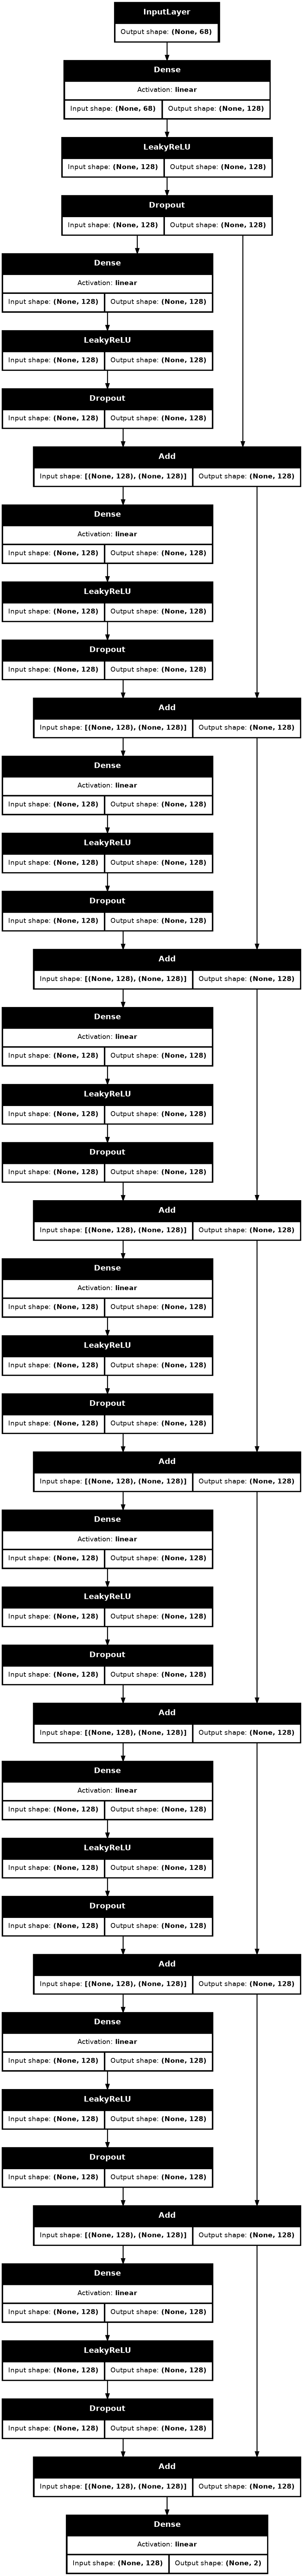

In [11]:
def image_path(model):
    ret = os.environ.get(
        f"PNG_{model.upper()}",
        f"/tmp/images/GlobalPID-im-{PARTICLE}/{model}.png"
    )
    os.makedirs(os.path.dirname(ret), exist_ok=True)
    return ret

def history_path():
    ret = os.environ.get(
        f"HISTORY_CSV",
        f"/tmp/history/GlobalPID-im-{PARTICLE}/training_history.csv"
    )
    os.makedirs(os.path.dirname(ret), exist_ok=True)
    return ret


tf.keras.utils.plot_model(
    generator.plain_keras,
    to_file=image_path('generator'),
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
    rankdir="TB",
    dpi=100,
)

### Discriminator architecture

TBA

In [12]:
discriminator((X[:256], y[:256]))
discriminator.summary()

Model: "discriminator_func"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_0 (Dense)     │ (None, 128)       │      1,024 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_0        │ (None, 128)       │          0 │ dense_0[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_0 (Dropout) │ (None, 128)       │          0 │ leaky_relu_0[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dropout_0[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_1        │ (None, 128)       │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ leaky_relu_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_0-1 (Add)       │ (None, 128)       │          0 │ dropout_0[0][0],  │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ add_0-1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_2        │ (None, 128)       │          0 │ dense_2[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ leaky_relu_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1-2 (Add)       │ (None, 128)       │          0 │ add_0-1[0][0],    │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ add_1-2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_3        │ (None, 128)       │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ leaky_relu_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2-3 (Add)       │ (None, 128)       │          0 │ add_1-2[0][0],    │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ add_2-3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_relu_4        │ (None, 128)       │          0 │ dense_4[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ leaky_relu_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3-4 (Add)       │ (None, 128)       │          0 │ add_2-3[0][0],    │
│                     │                   │            │ dropout_4[0][0] 

 Total params: 149,761 (585.00 KB)

 Trainable params: 149,761 (585.00 KB)

 Non-trainable params: 0 (0.00 B)

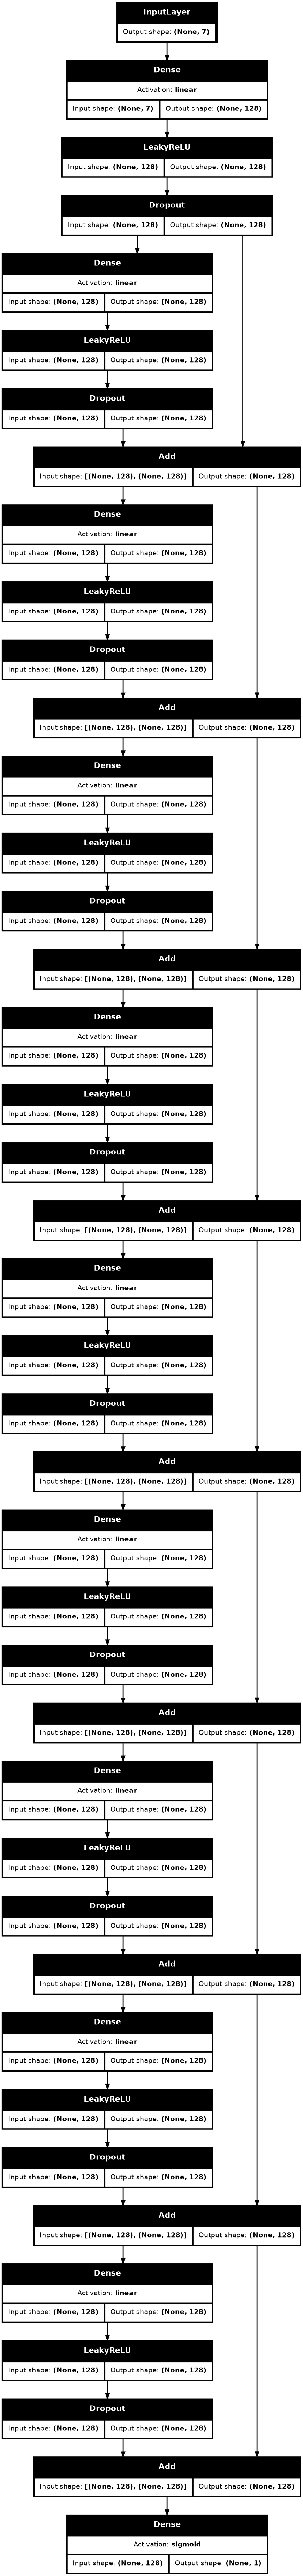

In [13]:
tf.keras.utils.plot_model(
    discriminator.plain_keras,
    to_file=image_path('discriminator'),
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
    rankdir="TB",
    dpi=100,
)

### Referee architecture

In [14]:
if referee is not None:
    referee((X[:256], y[:256]))
    referee.summary()

Model: "referee_seq"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,073 (262.00 KB)

 Trainable params: 67,073 (262.00 KB)

 Non-trainable params: 0 (0.00 B)

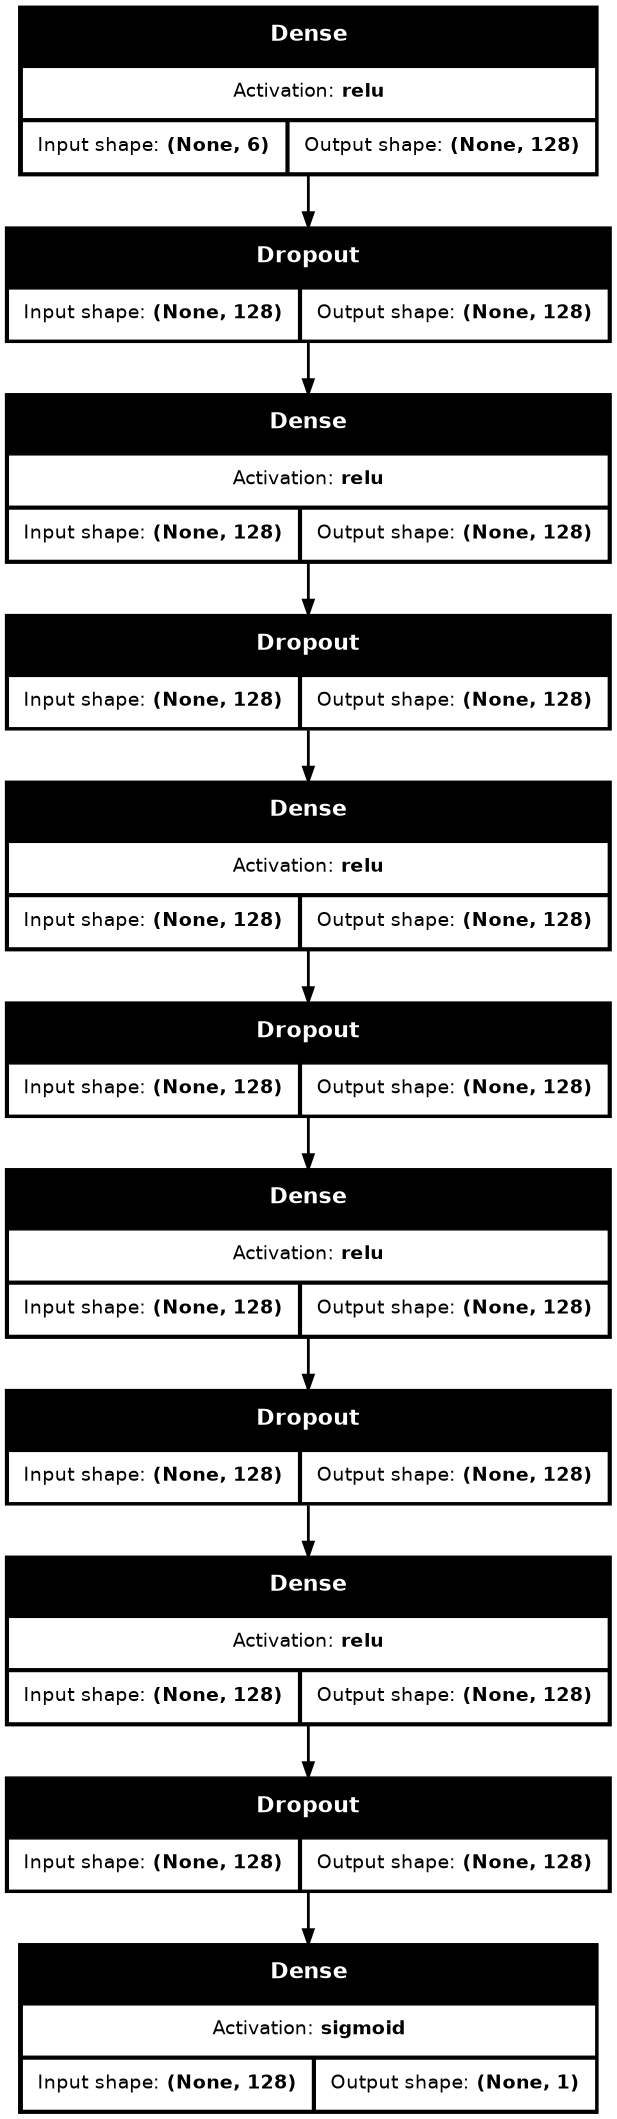

In [15]:
if referee is not None:
    display(
        tf.keras.utils.plot_model(
            referee.plain_keras,
            to_file=image_path('referee'),
            show_shapes=True,
            show_layer_names=False,
            show_layer_activations=True,
            rankdir="TB",
            dpi=100,
        )
    )
else:
    display("Referee not defined")

### Training setup

TBA

In [16]:
from pidgan.algorithms import BceGAN_ALP, BceGAN

# gan = BceGAN_ALP(
#     generator=generator,
#     discriminator=discriminator,
#     lipschitz_penalty=1.0,
#     lipschitz_penalty_strategy="one-sided",
#     feature_matching_penalty=0.0,
#     referee=referee,
# )

gan = BceGAN(
    generator=generator,
    discriminator=discriminator,
    from_logits=False,
    label_smoothing=0.05,
    injected_noise_stddev=0.02,
    feature_matching_penalty=0.0,
    referee=referee,
)

In [17]:
from tensorflow.keras.optimizers import RMSprop, Adam

g_lr0 = 7e-4
d_lr0 = 4e-4

gan.compile(
    metrics=["wass_dist"],
    generator_optimizer=RMSprop(g_lr0),
    discriminator_optimizer=RMSprop(d_lr0),
    generator_upds_per_batch=1,
    discriminator_upds_per_batch=1,
    referee_optimizer=RMSprop(1e-3),
    referee_upds_per_batch=1,
)

In [18]:
from pidgan.callbacks.schedulers import LearnRateExpDecay
from training_utils import TimeLimitCallback

callbacks = list()

g_lr_sched = LearnRateExpDecay(
    gan.generator_optimizer,
    decay_rate=0.1,
    decay_steps=100_000,
    min_learning_rate=g_lr0/1e3,
    verbose=True,
    key="g_lr",
)
callbacks.append(g_lr_sched)

d_lr_sched = LearnRateExpDecay(
    gan.discriminator_optimizer,
    decay_rate=0.1,
    decay_steps=200_000,
    min_learning_rate=d_lr0/1e3,
    verbose=True,
    key="d_lr",
)
callbacks.append(d_lr_sched)

TRAINING_TIME_LIMIT_SECONDS = int(environ.get("TRAINING_TIME_LIMIT_SECONDS", "7200"))
callbacks.append(TimeLimitCallback(TRAINING_TIME_LIMIT_SECONDS))

if referee is not None:
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='r_loss', 
        mode='max',
        start_from_epoch=100,
        patience=100,
    )
    callbacks.append(early_stopping)

# r_lr_sched = LearnRateExpDecay(
#     gan.referee_optimizer,
#     decay_rate=0.1,
#     decay_steps=150_000,
#     verbose=True,
#     key="r_lr",
# )
# callbacks.append(r_lr_sched)

In [19]:
from datetime import datetime

batch_size = 7_500
num_epochs = int(environ.get("MAX_EPOCHS", "1000"))
if TEST: num_epochs = 8


data_train = ds_train.repeat().batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
data_val = next(iter(ds_val.batch(batch_size)))

for epochs in 1, num_epochs:
    train = gan.fit(
        data_train, 
        epochs=epochs, 
        validation_data=data_val, 
        callbacks=callbacks, 
        steps_per_epoch=150,
        verbose=1 if TEST else 2
    )
    
if not TEST:
    prefix = ""
    timestamp = str(datetime.now())
    timestamp = timestamp.split(".")[0].replace("-", "").replace(" ", "-")
    for time, unit in zip(timestamp.split(":"), ["h", "m", "s"]):
        prefix += time + unit  # YYYYMMDD-HHhMMmSSs
else:
    prefix = "test"

debug: float32
debug: float32


I0000 00:00:1755680890.555540 1352054 service.cc:145] XLA service 0x7f277801dc80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755680890.555607 1352054 service.cc:153]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.10gb, Compute Capability 8.0
I0000 00:00:1755680897.182388 1352302 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5195', 48 bytes spill stores, 48 bytes spill loads

I0000 00:00:1755680897.779831 1352307 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5195', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1755680897.961601 1352316 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5747', 204 bytes spill stores, 204 bytes spill loads

I0000 00:00:1755680898.131672 1352298 asm_compiler.cc:369] ptxas warning : Registers are spilled to local 

 10/150 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - d_loss: 5.3748 - g_loss: 5.3367 - r_loss: 0.5441 - wass_dist: 0.0860 - g_lr: 6.9991e-04 - d_lr: 3.9997e-04

I0000 00:00:1755680903.547556 1352054 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 4.0273 - g_loss: 3.7438 - r_loss: 0.5006 - wass_dist: -0.1766 - g_lr: 6.9880e-04 - d_lr: 3.9966e-04debug: float32
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 125ms/step - d_loss: 3.9875 - g_loss: 3.7215 - r_loss: 0.5007 - wass_dist: -0.1741 - g_lr: 6.9878e-04 - d_lr: 3.9965e-04 - val_d_loss: 0.6803 - val_g_loss: 0.9043 - val_r_loss: 0.5663 - val_wass_dist: -0.0467
Epoch 1/8
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - d_loss: 0.6305 - g_loss: 1.0829 - r_loss: 0.5520 - wass_dist: -0.1353 - g_lr: 6.9637e-04 - d_lr: 3.9896e-04 - val_d_loss: 0.6694 - val_g_loss: 1.0059 - val_r_loss: 0.6031 - val_wass_dist: -0.0183
Epoch 2/8
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - d_loss: 0.6580 - g_loss: 0.9309 - r_loss: 0.6248 - wass_dist: -0.0833 - g_lr: 6.9397e-04 - d_lr: 3.9827e-04 - val_d_loss: 0.6783 - val_g_loss: 0.8544 - val_r_loss: 0.6048 - val_wass_dist: 0.0453
Epoch 3/8
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - d_loss: 0.6521 - g_loss: 0.9204 - r_los

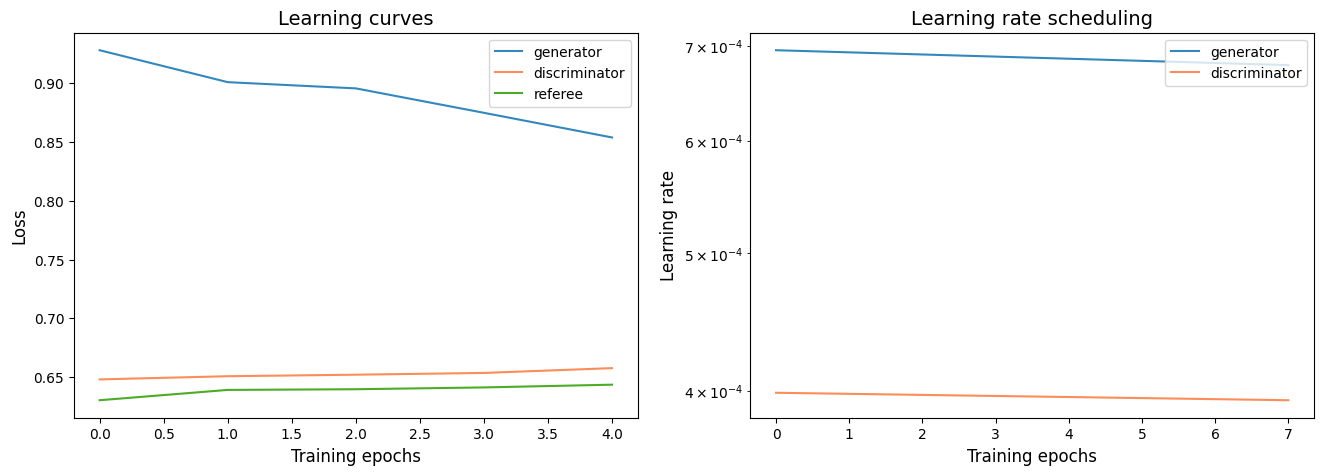

In [20]:
plt.figure(figsize=(16, 5), dpi=100)

start_epoch = 3

plt.subplot(1, 2, 1)
plt.title("Learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.plot(train.history["g_loss"][start_epoch:], color="#3288bd", label="generator")
plt.plot(train.history["d_loss"][start_epoch:], color="#fc8d59", label="discriminator")
plt.plot(train.history["r_loss"][start_epoch:], color="#4dac26", label="referee")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Learning rate scheduling", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Learning rate", fontsize=12)
plt.plot(train.history["g_lr"], color="#3288bd", label="generator")
plt.plot(train.history["d_lr"], color="#fc8d59", label="discriminator")
#plt.plot(train.history["r_lr"], color="#4dac26", label="referee")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.show()

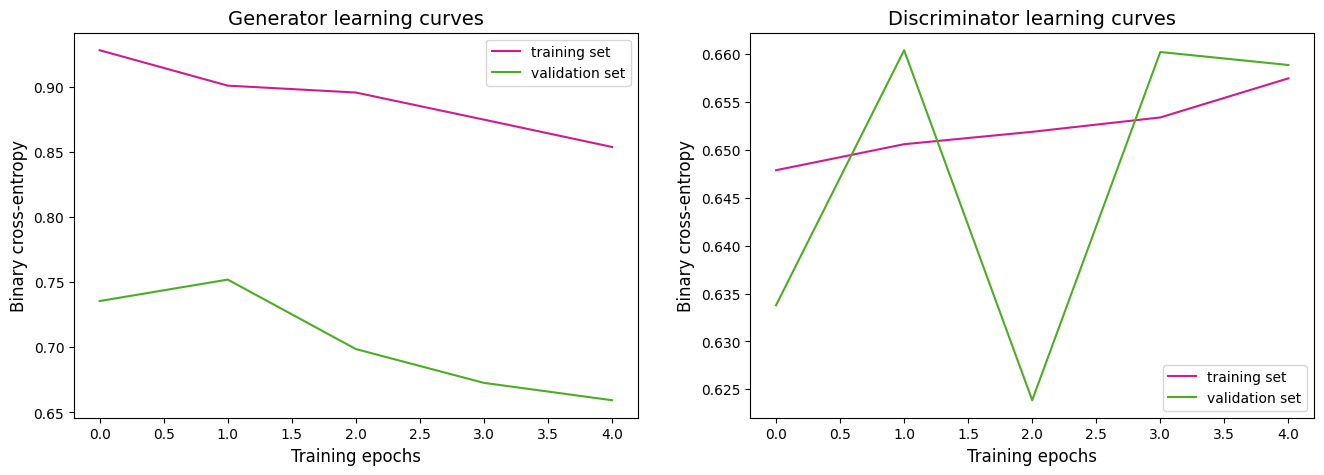

In [21]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Generator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["g_loss"][start_epoch:], color="#d01c8b", label="training set")
plt.plot(train.history["val_g_loss"][start_epoch:], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Discriminator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["d_loss"][start_epoch:], color="#d01c8b", label="training set")
plt.plot(train.history["val_d_loss"][start_epoch:], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

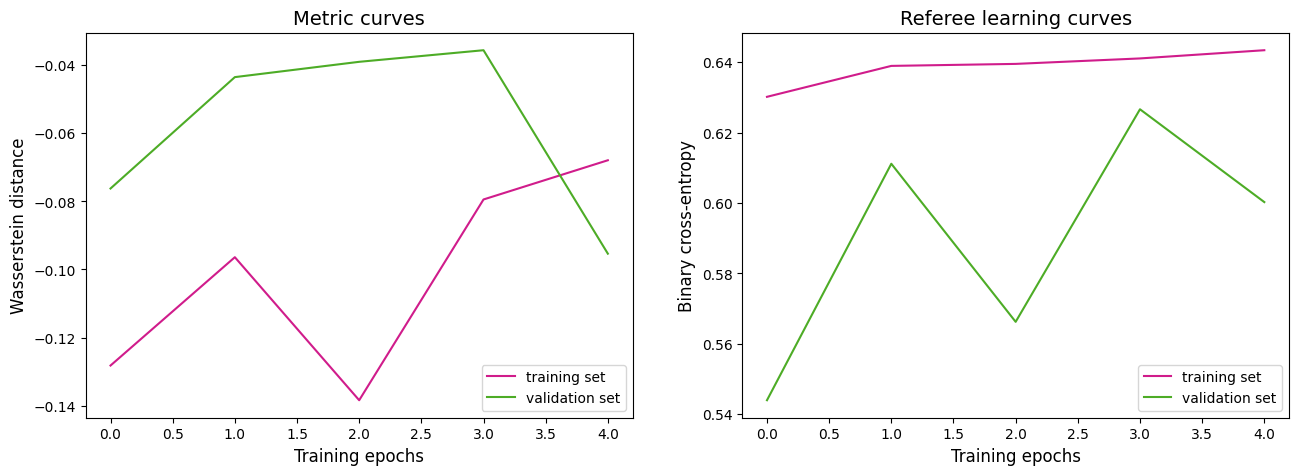

In [22]:
plt.figure(figsize=(24, 5), dpi=100)

# plt.subplot(1, 3, 1)
# plt.title("Metric curves", fontsize=14)
# plt.xlabel("Training epochs", fontsize=12)
# plt.ylabel("Binary cross-entropy", fontsize=12)
# plt.plot(train.history["bce"][start_epoch:], color="#d01c8b", label="training set")
# plt.plot(train.history["val_bce"][start_epoch:], color="#4dac26", label="validation set")
# plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 3, 2)
plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Wasserstein distance", fontsize=12)
plt.plot(train.history["wass_dist"][start_epoch:], color="#d01c8b", label="training set")
plt.plot(train.history["val_wass_dist"][start_epoch:], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)
# plt.yscale("log")

if referee is not None:
    plt.subplot(1, 3, 3)
    plt.title("Referee learning curves", fontsize=14)
    plt.xlabel("Training epochs", fontsize=12)
    plt.ylabel("Binary cross-entropy", fontsize=12)
    plt.plot(train.history["r_loss"][start_epoch:], color="#d01c8b", label="training set")
    plt.plot(train.history["val_r_loss"][start_epoch:], color="#4dac26", label="validation set")
    plt.legend(loc="lower right", fontsize=10)

plt.show()

In [23]:
train_history = train.history.copy()
pd.DataFrame(train_history).to_csv(history_path())

## A first, rough validation

TBA

In [27]:
reader_test = FeatherReader(environ.get("MUON_TEST_DATA", f"{DATA_PATH}/Muon-{PARTICLE}-test"), max_files=50)
head = reader_test.as_dask_dataframe().head(20_000_000, npartitions=-1)

In [28]:
X_test = head[reader_test.features].values
y_test = head[reader_test.labels].values
preds = gan.generator.predict(X_test, batch_size=50_000)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


In [29]:
X_test.shape, y_test.shape, preds.shape

((1039202, 4), (1039202, 2), (1039202, 2))

In [ ]:
# referee_true = gan.referee.predict((X_test, y_test), batch_size=50_000)
# referee_pred = gan.referee.predict((X_test, preds), batch_size=50_000)

In [ ]:
# plt.figure(figsize=(8, 5), dpi=100)
# plt.xlabel("Referee score", fontsize=12)
# plt.ylabel("Candidates", fontsize=12)
# 
# bins = np.linspace(0.0, 1.0, 101)
# plt.hist(referee_true, bins=bins, label="Detailed Simulation")
# plt.hist(referee_pred, bins=bins, histtype="step", lw=2, label="GAN-based model")
# plt.legend(fontsize=10)
# 
# plt.show()

In [ ]:
# from pidgan.optimization.scores import KSDistance
# 
# ks_dist = KSDistance()
# ks_score = ks_dist(referee_true, referee_pred, bins=100, range=[0.0, 1.0])
# 
# print(f"K-S distance (referee): {ks_score:.3f}")

In [ ]:
# chunk_size = 5_000_000
# 
# np.savez_compressed(
#     f"./exports/{prefix}-Muon-muon-referee.npz",
#     referee_true=referee_true[:chunk_size],
#     referee_pred=referee_pred[:chunk_size],
#     ks_score=ks_score,
# )

In [33]:
import pickle

def preprocessing_file(var, particle=PARTICLE, model="Muon"):
    if var not in "XY":
        raise ValueError(f"Unexpected var={var}. Should be X or Y.")
        
    model = model.upper().replace("-", "_")
    default = f"/tmp/s3models/lamarr-train/models/Muon/{particle}/t{var}.pkl"
    return os.environ.get(f"{model}_PREPROCESSING_{particle.upper()}_{var}", default)

   
with open(preprocessing_file('X'), "rb") as file:
    X_scaler = pickle.load(file)

with open(preprocessing_file('Y'), "rb") as file:
    y_scaler = pickle.load(file)
    

In [34]:
from pidgan.utils.preprocessing import invertColumnTransformer
print (X_scaler)
    
X_post = invertColumnTransformer(X_scaler, X_test)
y_post = y_scaler.inverse_transform(y_test)
preds_post = y_scaler.inverse_transform(preds)

ColumnTransformer(transformers=[('features',
                                 QuantileTransformer(output_distribution='normal'),
                                 array([0, 1, 2])),
                                ('flags', 'passthrough', array([3]))])


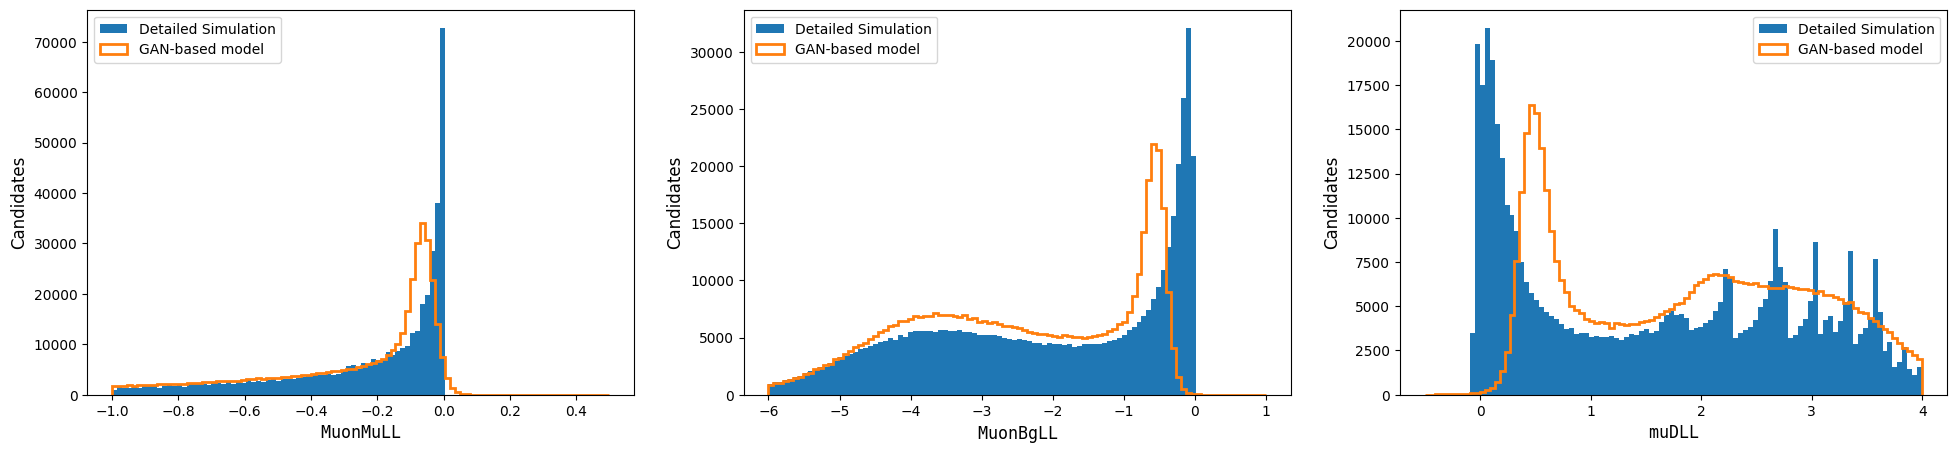

In [36]:
plt.figure(figsize=(24, 5), dpi=100)

# MuonMuLL
plt.subplot(1, 3, 1)
bins = np.linspace(-1.0, 0.5, 101)
plt.xlabel(r"$\mathtt{MuonMuLL}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(
    y_post[:, y_vars.index("MuonMuLL")][:500000],
    bins=bins,
    label="Detailed Simulation",
)
plt.hist(
    preds_post[:, y_vars.index("MuonMuLL")][:500000],
    bins=bins,
    histtype="step",
    lw=2, 
    label="GAN-based model",
)
plt.legend(fontsize=10)
# plt.yscale("log")

# MuonBgLL
plt.subplot(1, 3, 2)
bins = np.linspace(-6.0, 1.0, 101)
plt.xlabel(r"$\mathtt{MuonBgLL}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(
    y_post[:, y_vars.index("MuonBgLL")][:500000],
    bins=bins,
    label="Detailed Simulation",
)
plt.hist(
    preds_post[:, y_vars.index("MuonBgLL")][:500000],
    bins=bins,
    histtype="step",
    lw=2, 
    label="GAN-based model",
)
plt.legend(fontsize=10)
# plt.yscale("log")

# muDLL
plt.subplot(1, 3, 3)
bins = np.linspace(-0.5, 4.0, 101)
plt.xlabel(r"$\mathtt{muDLL}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(
    y_post[:, y_vars.index("MuonMuLL")][:500000] - y_post[:, y_vars.index("MuonBgLL")][:500000],
    bins=bins,
    label="Detailed Simulation",
)
plt.hist(
    preds_post[:, y_vars.index("MuonMuLL")][:500000] - preds_post[:, y_vars.index("MuonBgLL")][:500000],
    bins=bins,
    histtype="step",
    lw=2,
    label="GAN-based model",
)
plt.legend(fontsize=10)

plt.show()

## Data and model export

To simplify the preparation of LHCb figures and freeze the results obtained, the output of the trained model is exported and NumPy file and then uploaded to GitLab.

In [37]:
default_output_dataset = f"/tmp/Muon-{PARTICLE}-results.npz"

np.savez_compressed(
    os.environ.get("OUTPUT_VALIDATION_DATASET", default_output_dataset),
    feat_vars=np.array(x_vars[:3] + [x_vars[-1]]),
    label_vars=np.array(y_vars),
    results=np.c_[X_post[:, :3], X_post[:, -1], y_post, preds_post][:750_000],
)

Finally, we export the Keras model to the same folder where the preprocessing step was stored.

In [38]:
import os
default_output_model = "/tmp/models/Muon/model.keras"
output_model = os.environ.get('OUTPUT_MODEL', default_output_model)
base_dir = os.path.dirname(output_model)
os.makedirs(base_dir, exist_ok=True)
generator.plain_keras.save(output_model)